In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import io
from PIL import Image
import ipywidgets as widgets
from IPython.display import display

from sod_model import set_sod_model, optimizer


In [8]:
import os
print(os.getcwd())
print(os.listdir("."))


c:\Users\mil\Desktop\CNN Project\CNN Project
['.ipynb_checkpoints', 'app.ipynb', 'Dataset', 'data_loader.py', 'evaluate.py', 'sod_model.py', 'train.py', '__pycache__']


In [3]:
def load_trained_model():
    model = set_sod_model()
    opt = optimizer()  # needed ONLY so checkpoint restores correctly

    ckpt = tf.train.Checkpoint(model=model, optimizer=opt, step=tf.Variable(0))
    manager = tf.train.CheckpointManager(ckpt, './checkpoints', max_to_keep=3)

    if manager.latest_checkpoint:
        print(f"Loaded checkpoint: {manager.latest_checkpoint}")
        ckpt.restore(manager.latest_checkpoint).expect_partial()
    else:
        print("No checkpoint found. Model will be untrained.")

    return model

sod_model = load_trained_model()


No checkpoint found. Model will be untrained.


In [4]:
def preprocess_uploaded_image(img):
    img = img.resize((128, 128))       # Same size as your model input
    arr = np.array(img).astype(np.float32) / 255.0

    # If grayscale → convert to RGB
    if len(arr.shape) == 2:
        arr = np.stack([arr, arr, arr], axis=-1)

    return arr


In [5]:
def predict_saliency(model, img):
    inp = preprocess_uploaded_image(img)
    inp_tensor = tf.expand_dims(inp, 0)  # Shape: (1, 128, 128, 3)

    pred = model(inp_tensor, training=False)
    pred_mask = tf.cast(pred > 0.5, tf.float32)[0].numpy().squeeze()

    return inp, pred_mask


In [6]:
def visualize_prediction(image, pred_mask):
    overlay = image.copy()
    overlay[..., 0] = np.maximum(overlay[..., 0], pred_mask)  # Red highlight

    plt.figure(figsize=(12, 4))

    # Original
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.title("Predicted Saliency Mask")
    plt.imshow(pred_mask, cmap="gray")
    plt.axis("off")

    # Overlay
    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.show()


FileUpload(value=(), accept='image/*', description='Upload')

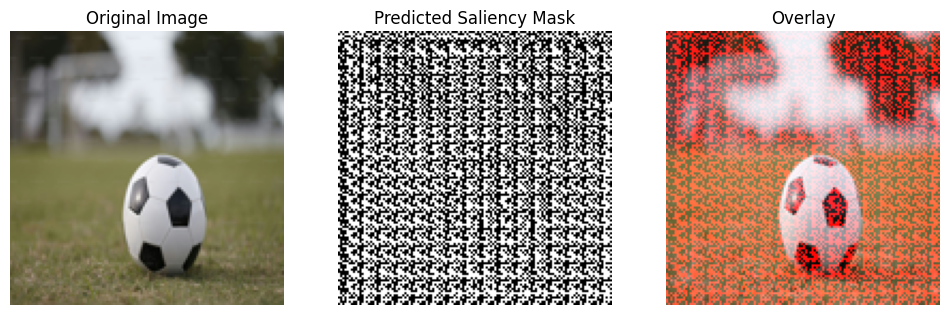

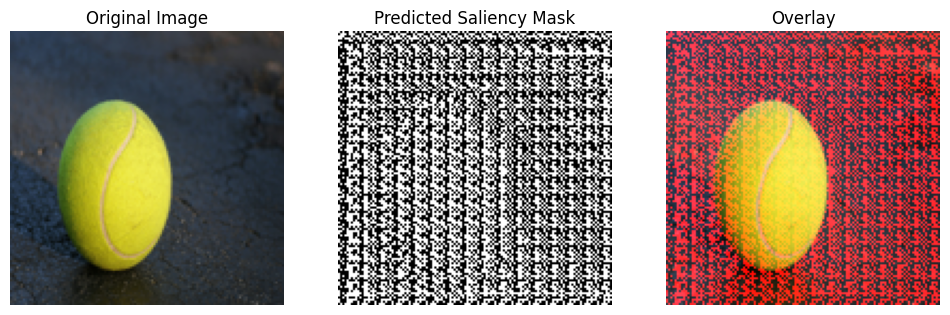

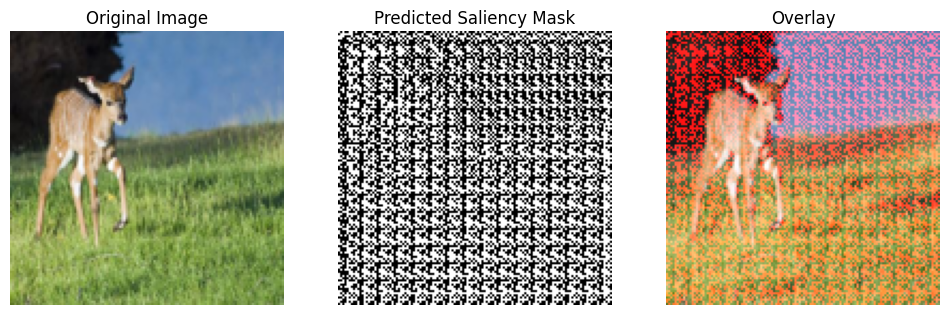

In [ ]:
upload_btn = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    if upload_btn.value:

        # Case 1: ipywidgets returns a dict (new behavior)
        if isinstance(upload_btn.value, dict):
            file_info = list(upload_btn.value.values())[0]
            content = file_info['content']

        # Case 2: ipywidgets returns a tuple (older versions)
        elif isinstance(upload_btn.value, tuple):
            file_info = upload_btn.value[0]  # first file
            content = file_info['content']

        else:
            print("Unsupported upload format:", type(upload_btn.value))
            return

        # Load image
        img = Image.open(io.BytesIO(content)).convert('RGB')

        # Prediction
        image, mask = predict_saliency(sod_model, img)

        # Visualization
        visualize_prediction(image, mask)

upload_btn.observe(on_upload_change, names='value')
display(upload_btn)
